In [1]:
!pip install matplotlib
!pip install yfinance
!pip install seaborn
!pip install numpy
!pip install quandl
!pip install py_vollib

import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import quandl, math
import datetime
from matplotlib import style
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import delta, gamma, vega, theta, rho
from pandas_datareader import data as pdr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 555 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 6.9 MB/s 
  Created wheel for py-vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62855 sha256=ded395e99ddf49457ef2ddc7cf97dba700f3074

[*********************100%***********************]  1 of 1 completed


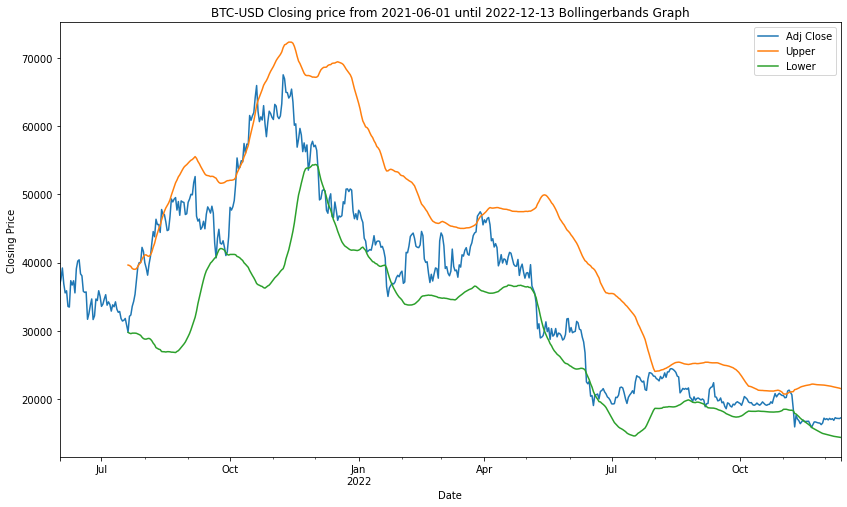

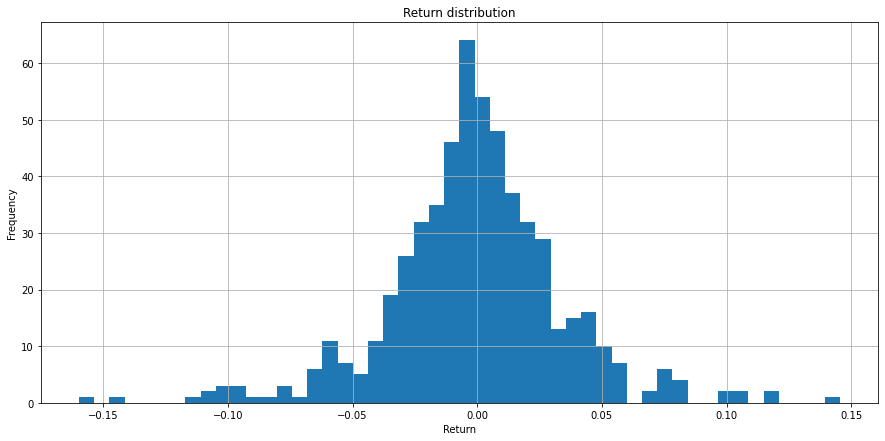

   curr_adj_upper  pre_adj_lower          diff   precent
0    63079.344460   40821.123033  22258.221427  0.545262
1    46967.998338   37199.673534   9768.324804  0.262592
2    20932.596865   19011.304691   1921.292174  0.101061
{'curr_adj_upper': [63079.344459822394, 46967.998338032936, 20932.596864701012], 'pre_adj_lower': [40821.123032821764, 37199.67353379509, 19011.304690823967], 'diff': [22258.22142700063, 9768.324804237847, 1921.2921738770456], 'precent': [0.545262348836022, 0.2625916809555744, 0.10106051137060468]}
Revenue in precentages: 90.8914541162201
I would buy the stock: 37 times


In [3]:
from requests.models import stream_decode_response_unicode
import pandas as pd
import sys
stock_name = "BTC-USD"
start_date = '2021-06-01' 
end_date = '2022-12-13'
std_parameter = 2


def create_graph(stock_name, start_date, end_date,std_parameter):
  data_stock = yf.download(stock_name, start=start_date, end=end_date)
  data_stock['Moving Average 50'] = data_stock['Adj Close'].rolling(window=50).mean()
  data_stock['STD 50'] = data_stock['Adj Close'].rolling(window=50).std() 
  data_stock['Upper'] = data_stock['Moving Average 50'] + (data_stock['STD 50'] * std_parameter)
  data_stock['Lower'] = data_stock['Moving Average 50'] - (data_stock['STD 50'] * std_parameter)
  ax = data_stock[['Adj Close', 'Upper', 'Lower']].plot(figsize=(14, 8))
  ax.set_title(f"{stock_name} Closing price from {start_date} until {end_date} Bollingerbands Graph")
  ax.set_ylabel('Closing Price')
  ax.set_xlabel('Date')
  count_up = 0
  count_down = 0
  pre_upp = 0
  pre_low = sys.maxsize
  flag = 0
  data = {'curr_adj_upper': [],
          'pre_adj_lower': [],
          'diff':[],
          'precent':[],
          }
  
  ##Distribution calc
  fig = plt.figure(figsize=(15, 7))
  ax1 = fig.add_subplot(1, 1, 1)
  data_stock['Adj Close'].pct_change().hist(bins=50, ax=ax1)
  ax1.set_xlabel('Return')
  ax1.set_ylabel('Frequency')
  ax1.set_title('Return distribution')
  plt.show()

  for adj, upp, low, idx in zip(list(data_stock['Adj Close']),
                            list(data_stock['Upper']),
                                 list(data_stock['Lower']), list(data_stock.index)):
                            
                            if adj > upp:
                              ax.scatter(idx, adj, color='r', marker='v')
                              count_up += 1
                              if flag == 0:
                                flag = "upper"
                              if flag == "lower": #last adj was lower
                                pre_upp = upp
                                flag = "upper"
                              else:#upper
                                if pre_upp < upp: # current val is local_max and same lower group
                                  pre_upp = upp

                            elif adj < low:
                              ax.scatter(idx, adj, color='g', marker='^')
                              count_down += 1
                              if flag == 0:
                                flag = "lower"
                              if flag == "upper":
                                if pre_low < sys.maxsize:
                                  data['curr_adj_upper'].append(pre_upp)
                                  data['pre_adj_lower'].append(pre_low)
                                  data['diff'].append(pre_upp - pre_low)
                                  data['precent'].append(pre_upp/pre_low-1)
                                pre_low=low
                                flag = "lower"
                              else:#lower
                                if pre_low > low:
                                  pre_low = low
  if flag == 'upper':
    data['curr_adj_upper'].append(pre_upp)
    data['pre_adj_lower'].append(pre_low)
    data['diff'].append(pre_upp - pre_low)
    data['precent'].append(pre_upp/pre_low-1)
                              

                              
  df = pd.DataFrame(data)
  print (df)
  print(data)
  sum_precent = pd.Series(data['precent']).sum() * 100
  print(f"Revenue in precentages: {sum_precent}")
  return count_up, count_down

count_up, count_down = create_graph(stock_name, start_date, end_date,std_parameter)
print(f"I would buy the stock: {count_down} times")

###

